In [1]:
#imports
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random
from bayes_opt import BayesianOptimization

In [2]:
#function for getting rate graphs
def change_coord(data, init,num):
    
    rate_lists = []
    
    for line in range(num):
        rate_list = []
        for i in range(len(data[line])-1):
            rate_list.append((data[line][i+1]-data[line][i])/(timespan[i+1]-timespan[i]))   
        rate_lists.append(rate_list)

    return rate_lists

In [81]:
#needed parameters
T = [323,363,393]
P = 50
KH= 1282
CH2 = P/KH
R= 8.314

timespan = [0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246]
print(timespan)
time = timespan[-1]

colors = ['#2DE8A0','#1EBAEE','#2652E3','#9C4CE8','#F05BEE','#BF2947']

[0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246]


In [82]:
#function for getting activation energy from rate constants and pre factors
def get_Eact(A, ktrue):
    T=363
    E = (np.log(ktrue/A))*R*T
    return E

In [83]:
#function for getting noise
def get_noise():
    static_noise = np.random.normal(0,0.01,30)
    variable_noise = np.random.normal(0,0.05,30)
    return static_noise, variable_noise

In [84]:
#function to run ODE simulation and make data out of it
def simulate_system(diff,pre_consts, E_acts,T, inits):
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    sol_list = []
    for init in inits:
        sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan, args=[rate_consts])
        sol_list.append(sol.y)

    noisy_data_lists = []
    i = 0
    for sol in sol_list:
        noisy_data = []
        for line in sol:
            static_noise,variable_noise = get_noise()
            noisy_data.append(line + static_noise + np.multiply(line,variable_noise))

        noisy_data_lists.append(noisy_data)

    num = len(sol_list[0])
    rate_lists = []
    for i in range(len(noisy_data_lists)):
        rate_lists.append(change_coord(noisy_data_lists[i],inits[i],num))
        i+=1
        
    return sol_list, noisy_data_lists, rate_lists

In [86]:
#function for getting r2_score more easily
def get_r2(real,simul):
    if len(simul)<4 or len(real)<= 4:
        return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2]))
    return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2])) + (r2_score(real[3], simul[3]))

In [87]:
#get the r2_score for the real system
def true_r2(diff,pre_consts,E_acts,inits,T, noisy_data, rate_data):
    #test R squared comparison for random values
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    ind = {}
    for i in range(len(rate_consts)):
        ind[f'k{i+1}'] = rate_consts[i]
    print(ind)
    best_list = []
    for init in inits:
        best = integrate.solve_ivp(diff, [0,time], init, args = (ind,), t_eval = timespan)
        best_list.append(best.y)
        
    num = len(best_list[0])
    changed_rates = []
    for i in range(len(best_list)):
        changed_rate = change_coord(best_list[i],inits[i],num)
        changed_rates.append(changed_rate)

    score = 0
    
    for i in range(len(noisy_data)):
        score += get_r2(noisy_data[i], best_list[i])
    for i in range(len(rate_data)):
        score += get_r2(rate_data[i], changed_rates[i])
    
    return score

In [88]:
#function for converting erros to SMAPE scores
def get_SMAPE(real,sim):
    tot = 0
    for i in range(len(real)):
        tot += np.abs(np.abs(real[i])-np.abs(sim[i]))/((np.abs(real[i])+(np.abs(sim[i]))/2))
    return(tot)

In [89]:
#main workhorse of the script, guesses rate constants, and minimizes the residual of the outcome
def fit_sim(diff, inits, noisy_data, rate_data, max_score, consts):
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        subject = {}
        for const in consts:
            subject[const] = paras[const].value
            

        
        sol_list = []
        
        for init in inits:
            sol = integrate.solve_ivp(diff, [0,time], init, args = (subject,), t_eval = timespan)
            sol_list.append(sol.y)

        
        num = len(sol_list[0])
        changed_rates = []
        
        for i in range(len(sol_list)):
            changed_rate = change_coord(sol_list[i],inits[i], num)
            changed_rates.append(changed_rate)

        score = 0
    
        for i in range(len(noisy_data)):
            score += get_r2(noisy_data[i], sol_list[i])
        for i in range(len(rate_data)):
            score += get_r2(rate_data[i], changed_rates[i])

#         print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score

    

    params = Parameters()
    for const in consts:
        params.add(const,value=0.01, min=1e-10, max=1)
    


    results = minimize(residual, params, method='leastsq', max_nfev = 1000)  # leastsq nelder

    
    fin_sub = {}
    for const in consts:
            fin_sub[const] = results.params[const].value
    
    data_fitted = integrate.solve_ivp(diff, [0,time], inits[0], args = (fin_sub,), t_eval = timespan)
    sim = residual(results.params)[0]
    score = max_score - sim
    print(sim)


    plt.figure()
    plt.scatter(timespan, noisy_data[0][0], marker='o', color='b', label='measured data CE')
    plt.scatter(timespan, noisy_data[0][1], marker='o', color='b', label='measured data CA1')
    plt.scatter(timespan, noisy_data[0][2], marker='o', color='b', label='measured data CA2')
    plt.scatter(timespan, noisy_data[0][3], marker='o', color='b', label='measured data CtE')
    plt.plot(timespan, data_fitted.y[0], '-', linewidth=2, color='red', label='fitted data CE')
    plt.plot(timespan, data_fitted.y[1], '-', linewidth=2, color='red', label='fitted data CA1')
    plt.plot(timespan, data_fitted.y[2], '-', linewidth=2, color='red', label='fitted data CA2')
    plt.plot(timespan, data_fitted.y[3], '-', linewidth=2, color='red', label='fitted data CtE')
    plt.legend()

    report_fit(results)
    
    return results.params, score

In [90]:
#for kinetic parameter fittin we need a function to synthesize rate constants out of the parameters, and then run simulations with it
def get_lines(diff,T, inits,constants):
    ind_const = {}
    half = int(len(constants)/2)
    for i in range(half):
        ind_const[f'k{i+1}'] = constants[f'A{i+1}']*np.exp(-constants[f'E{i+1}']/(R*T))

    lines_list = []
    for init in inits:
        lines = integrate.solve_ivp(diff, [0,time], init, args = (ind_const,), t_eval = timespan)
        lines_list.append(lines.y)

    return lines_list

In [91]:
#main workhorse of the script, guesses kinetic constants, and minimizes the residual of the outcome
def fit_sim_full(diff, inits, noisy_data, rate_data, max_score, temperatures, guesses, consts):
    
    pre_consts = []
    E_acts = []
    
    for i in range(len(consts)):
        pre_consts.append(f'A{i+1}')
        E_acts.append(f'E{i+1}')
        
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        
        subject = {}
        for pre_const in pre_consts:
            subject[pre_const] = paras[pre_const].value
        for E_act in E_acts:
            subject[E_act] = paras[E_act].value
        
        half = int(len(subject)/2)
        for i in range(half):
            val = subject[f'A{i+1}']*np.exp(-subject[f'E{i+1}']/(R*T[-1]))
            if val > 1:
                return max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,
        
        
        lines_list = []
        rates_list = []

        for temp in temperatures:
            rates_int = []
            lines = get_lines(diff,temp,inits,subject)
            lines_list.append(lines)
            num = len(lines[0])
            for i in range(len(lines)):
                rates_int.append(change_coord(lines[i],inits[i],num))
            rates_list.append(rates_int)

        score = 0
         
        for i in range(len(noisy_data)):
            for j in range(len(noisy_data[i])):
                score += get_r2(noisy_data[i][j], lines_list[i][j])
        for i in range(len(rate_data)):
            for j in range(len(rate_data[i])):
                score += get_r2(rate_data[i][j], rates_list[i][j])                                                                            
        print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score


    params = Parameters()
    for i in range(len(pre_consts)):
        params.add(pre_consts[i],value=guesses[1,i], min=1e-5, max=1e5)
    for i in range(len(E_acts)):
        params.add(E_acts[i],value=guesses[0,i], min=1000, max=100000)

    results = minimize(residual, params, method='leastsq', max_nfev = 200)  # leastsq nelder
    report_fit(results)
    
    sim = residual(results.params)[0]
    score = max_score - sim
    print(sim)
    
    fin_sub = {}
    for pre_const in pre_consts:
        fin_sub[pre_const] = results.params[pre_const].value
    for E_act in E_acts:
        fin_sub[E_act] = results.params[E_act].value
      
    mock_run = get_lines(diff,temperatures[0],inits,fin_sub)
    
    
    if len(mock_run[0]) >=4 and len(noisy_data[0][0]) >= 4:
        for i in range(len(temperatures)):
            data_fitted = get_lines(diff,temperatures[i],inits,fin_sub)
            plt.figure(i)
            plt.plot(timespan, data_fitted[0][0], '-', linewidth=2, color='red', label='fitted data CE')
            plt.plot(timespan, data_fitted[0][1], '-', linewidth=2, color='red', label='fitted data CA1')
            plt.plot(timespan, data_fitted[0][2], '-', linewidth=2, color='red', label='fitted data CA2')
            plt.plot(timespan, data_fitted[0][3], '-', linewidth=2, color='red', label='fitted data CtE')
            plt.scatter(timespan, noisy_data[i][0][0], marker='o', color='b', label='measured data CE')
            plt.scatter(timespan, noisy_data[i][0][1], marker='o', color='b', label='measured data CA1')
            plt.scatter(timespan, noisy_data[i][0][2], marker='o', color='b', label='measured data CA2')
            plt.scatter(timespan, noisy_data[i][0][3], marker='o', color='b', label='measured data CtE')
            plt.legend()
    else:
        for i in range(len(temperatures)):
            data_fitted = get_lines(diff,temperatures[i],inits,fin_sub)
            plt.figure(i)
            plt.plot(timespan, data_fitted[0][0], '-', linewidth=2, color='red', label='fitted data CE')
            plt.plot(timespan, data_fitted[0][1], '-', linewidth=2, color='red', label='fitted data CA1')
            plt.plot(timespan, data_fitted[0][2], '-', linewidth=2, color='red', label='fitted data CA2')
            plt.scatter(timespan, noisy_data[i][0][0], marker='o', color='b', label='measured data CE')
            plt.scatter(timespan, noisy_data[i][0][1], marker='o', color='b', label='measured data CA1')
            plt.scatter(timespan, noisy_data[i][0][2], marker='o', color='b', label='measured data CA2')
            plt.legend()


    print(residual(results.params)[0])
    
    return results.params, score

In [114]:
#class that takes the data, and the systems wit all the parameters ,and handles the fitting
class fitting_set:
    def __init__(self,true_system, sim_system, pre_constants, E_acts, sim_consts, temperatures, inits, sim_inits):
        self.true_system = true_system
        self.sim_system = sim_system
        self.pre_constants = pre_constants
        self.E_acts = E_acts
        self.consts = []
        self.real_rates_dict = {'temp': []}
        for const in sim_consts:
            self.real_rates_dict[const] = []
        for i in range(len(pre_constants)):
            self.consts.append(f'k{i+1}')
        for T in temperatures:
            self.real_rates_dict['temp'].append(T)
            for i in range(len(sim_consts)):
                self.real_rates_dict[sim_consts[i]].append(pre_constants[i]*np.exp(E_acts[i]/(R*T)))
                
        self.sim_consts = sim_consts
        self.temperatures = temperatures
        self.inits = inits
        self.sim_inits = sim_inits
        self.sim_rates_dict = {'temp': []}
        for const in self.sim_consts:
            self.sim_rates_dict[const] = []
        self.ind_fits_scores = []
        
    def get_true_data(self):
        self.true = []
        self.noisy = []
        self.rates = []
        for temperature in self.temperatures:
            sim = simulate_system(self.true_system,self.pre_constants,self.E_acts,temperature,self.inits)
            self.true.append(sim[0])
            self.noisy.append(sim[1])
            self.rates.append(sim[2])
        
    def get_true_r2(self):
        for i in range(len(self.temperatures)):
            print(true_r2(self.true_system,self.pre_constants,self.E_acts,self.inits,self.temperatures[i],self.noisy[i],self.rates[i]))
        
    def fit_sys(self,temp_num,max_score):
        fit_sim(self.sim_system, self.sim_inits, self.noisy[temp_num], self.rates[temp_num], max_score, self.sim_consts)
        
    def fit_sys_all(self,max_score):
        for i in range(len(self.temperatures)):
            fits, score = fit_sim(self.sim_system, self.sim_inits, self.noisy[i], self.rates[i], max_score, self.sim_consts)
            self.ind_fits_scores.append(score)
            self.sim_rates_dict['temp'].append(self.temperatures[i])
            for const in self.sim_consts:
                self.sim_rates_dict[const].append(fits[const].value)
                
        
    def kin_params_guesses(self):
        self.Eact_list = []
        self.A_list = []
        i=0
        for variable,lis in self.sim_rates_dict.items():
            log_list = np.log(lis)
            reciprocal_list = 1/np.array(self.sim_rates_dict['temp'])
            lin_model = np.polyfit(reciprocal_list,log_list,1)
            slope = lin_model[0]
            intercept = lin_model[1]
            self.Eact_list.append(slope*8.314)
            self.A_list.append(np.exp(intercept))
            if i >0:            
                plt.scatter(reciprocal_list,log_list, label = f'k{i}', color = colors[i-1])
                plt.plot(reciprocal_list, np.array(reciprocal_list)*slope+intercept, label = f'fit k{i}', color = colors[i-1])
            i+=1
            plt.title('Arrhenius plot example')
            plt.xlabel('1/T')
            plt.ylabel('ln(k)')
            plt.legend()
        plt.savefig("C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/arr_plot_example.svg",dpi=300)
        del self.Eact_list[0]
        del self.A_list[0]
        
    def fit_sys_full(self,max_score):
        guesses = np.zeros([2,6])
        guesses[0,:] = self.Eact_list
        guesses[0,:] *= -1
        guesses[1,:] = self.A_list
        for guess in guesses[0,:]:
            if guess <1000:
                guess = 1000
        for guess in guesses[1,:]:
            if guess > 1:
                guess = 1
        fits, self.full_fit_score = fit_sim_full(self.sim_system, self.sim_inits, self.noisy, self.rates, max_score, self.temperatures, guesses, self.sim_consts)
        self.A_ests = []
        self.E_ests = []
        for i in range(int(len(fits)/2)):
            self.A_ests.append(fits[f'A{i+1}'].value)
            self.E_ests.append(fits[f'E{i+1}'].value)
            

        
    def get_final_scores(self,ind_max, full_max):
        ind_score = 0
        for i in range(len(self.temperatures)):
            ind_score += self.ind_fits_scores[i]/(ind_max*len(self.temperatures))
        SMAPE_tot = 0
        for key in self.real_rates_dict.keys():
            SMAPE_tot += get_SMAPE(self.real_rates_dict[key],self.sim_rates_dict[key])
        SMAPE_k = SMAPE_tot
        SMAPE_kin = get_SMAPE(self.pre_constants,self.A_ests) + get_SMAPE(self.E_acts,self.E_ests)
#         SMAPE_tot += get_SMAPE(self.pre_constants,self.A_ests)
#         SMAPE_tot += get_SMAPE(self.E_acts,self.E_ests)
        SMAPE_tot += SMAPE_kin
        #return 1-ind_score, 1-(self.full_fit_score/full_max), SMAPE_tot/(len(self.consts)*5)
        return SMAPE_k/(len(self.consts)*3),SMAPE_kin/(len(self.consts)*2), SMAPE_tot/(len(self.consts)*5)
        
        

In [115]:
#different differential systems
def diff(x, init, rate_const):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
    try:
        k1, k2, k3, k4, k5, k6= rate_const['k1'],rate_const['k2'],rate_const['k3'],rate_const['k4'],rate_const['k5'],rate_const['k6']
    except:
        k1,k2,k3,k4,k5,k6 = rate_const
    dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
    dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
    dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
    dcatdeaddt = k6*Cprecat
    dH2uptakedt = k5*Ccat*CH2
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

In [116]:
def diff_simple(x, init, rate_const):
    CE, CA1, CA2 = init
    try:
        k1= rate_const['k1']
    except:
        k1 = rate_const[0]
    dEdt = -k1*CE
    dA1dt = k1*CE
    dA2dt = k1*CE
    return dEdt, dA1dt, dA2dt

In [122]:
#parameters to make a fitting system
init_true = [[1,0,0,0,1,0,0,0], [4,0,0,0,2,0,0,0], [8,0,0,0,1.5,0,0,0]]
exp_1_const = np.array([0.01209668296564242, 0.01517495478255645, 0.0042608145032644508, 0.0897487647678990227, 0.032891811706016034, 0.012690318715024702])
exp_1_pre_consts = np.array([4, 1.6, 1, 5, 2, 40])
exp_1_sim_consts = ["k1", "k2", "k3", "k4", "k5", "k6"]
exp_1_temps = np.array([323,363,393])
exp_1_E_acts = get_Eact(exp_1_pre_consts,exp_1_const)
exp_1 = fitting_set(diff,diff,exp_1_pre_consts,exp_1_E_acts, exp_1_sim_consts, exp_1_temps,init_true, init_true)

In [123]:
print(exp_1_E_acts)

[-17507.67079081 -14058.09983295 -16473.03587668 -12132.82763899
 -12396.90042988 -24312.24532045]


In [127]:
exp_1.get_true_data()

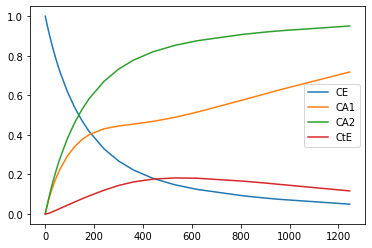

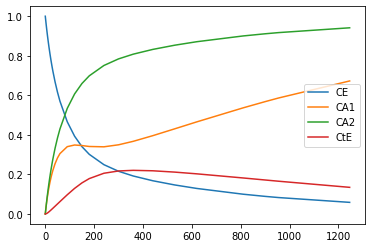

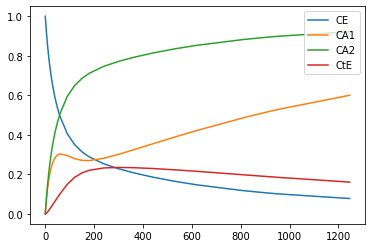

In [129]:
#plotting if the data is valid
for exp in exp_1.true:
    plt.figure()
    plt.plot(timespan,exp[0][0], label = 'CE')
    plt.plot(timespan,exp[0][1], label = 'CA1')
    plt.plot(timespan,exp[0][2], label = 'CA2')
    plt.plot(timespan,exp[0][3], label = 'CtE')
#     plt.plot(timespan,exp[0][4], label = 'Cprecat')
#     plt.plot(timespan,exp[0][5], label = 'Ccat')
#     plt.plot(timespan,exp[0][6], label = 'Ccatdead')
    plt.legend()

In [131]:
#get the true r2 to compare results to
exp_1.get_true_r2()

{'k1': 0.005897488188304271, 'k2': 0.00852318684494476, 'k3': 0.0021673614418580064, 'k4': 0.054552268043115824, 'k5': 0.019777261717591168, 'k6': 0.004679623618940348}
16.635265106897926
{'k1': 0.01209668296564243, 'k2': 0.015174954782556448, 'k3': 0.004260814503264448, 'k4': 0.08974876476789903, 'k5': 0.03289181170601603, 'k6': 0.012690318715024712}
18.025166395084025
{'k1': 0.01883590224472234, 'k2': 0.021654807126415244, 'k3': 0.006463196927233503, 'k4': 0.12198500798488923, 'k5': 0.0450056034587339, 'k6': 0.02347146917101018}
18.939723262215082


7.356863235903436
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 985
    # data points      = 6
    # variables        = 6
    chi-square         = 324.740620
    reduced chi-square = 324.740620
    Akaike info crit   = 35.9476038
    Bayesian info crit = 34.6981606
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.00569802 (init = 0.01)
    k2:  0.00882894 (init = 0.01)
    k3:  0.00231595 (init = 0.01)
    k4:  0.05524238 (init = 0.01)
    k5:  0.01945398 (init = 0.01)
    k6:  0.00456416 (init = 0.01)
5.963410398584504
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 213.373581
    reduced chi-square = 213.373581
    Akaike info crit   = 33.4277104
    Bayesian info crit = 32.1782672
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.01263573 (init = 0.01)
    k2:  0.01505007 (init = 0.01)
   

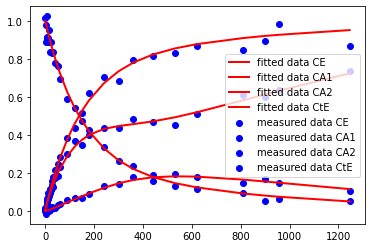

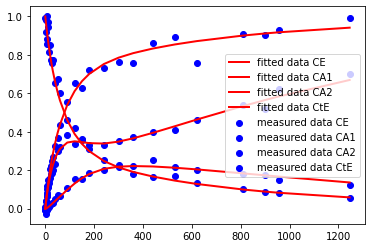

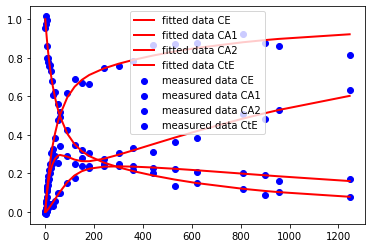

In [133]:
#do the per temperature fits
#exp_1.fit_sys(1,24)
exp_1.fit_sys_all(24)
#exp_1.fit_sys_all(32)
#exp_1.fit_sys_full(72)

In [134]:
# exp_simp.fit_sys_all(18)

No handles with labels found to put in legend.


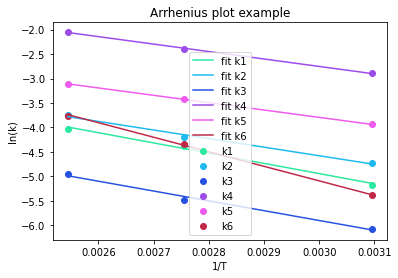

In [135]:
#guess the parameters from them
exp_1.kin_params_guesses()

In [37]:
#some checks
print(exp_1.sim_rates_dict)
print(exp_1.Eact_list)
print(exp_1.A_list)


{'temp': [323, 363, 393], 'k1': [0.005897547031767634, 0.012096675394882595, 0.01883868986988791], 'k2': [0.008522822070603536, 0.01517363195022328, 0.021260468744137197], 'k3': [0.002167213724657155, 0.004260333949608958, 0.0062783184754647186], 'k4': [0.054546926827592816, 0.08972181427733507, 0.11415769863934913], 'k5': [0.019777520937372554, 0.03289174440117545, 0.04511818843086963], 'k6': [0.004679436413211453, 0.012688395755715868, 0.022877716887376724]}
[-17509.526760312907, -13808.117853646214, -16078.341521104196, -11229.896224832419, -12430.735970422815, -23963.34220025149]
[4.0027095310083975, 1.4618340931642284, 0.8671129812408487, 3.6084494469055297, 2.0246007531346892, 35.26306837423064]


In [38]:
print(exp_1.pre_constants)
print(exp_1.E_acts)

[ 4.   1.6  1.   5.   2.  40. ]
[-17507.67079081 -14058.09983295 -16473.03587668 -12132.82763899
 -12396.90042988 -24312.24532045]


71.99930552485284
71.99930552485284
71.99930552485284
71.99930553415952
71.99930564232774
71.99930560170667
71.99930555345297
71.99930552966916
71.99930554137266
71.99930552467883
71.99930552237613
71.99930552363575
71.99930552387086
71.99930552474933
71.9993055229453
71.97454220084481
71.93315511609717
71.99868059210938
71.99930552485284
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 12
    # variables        = 12
    chi-square         = 5.7875e-06
    reduced chi-square = 5.7875e-06
    Akaike info crit   = -150.536500
    Bayesian info crit = -144.717621
##  Warning: uncertainties could not be estimated:
    A1:  at initial value
    A2:  at initial value
    A3:  at initial value
    A4:  at initial value
    A5:  at initial value
    A6:  at initial value
    E1:  at initial value
    E2:  at initial value
    E3:  at initial value
    E4:  at initial value
    E5:  at initial value
    E6:  at initial value
[[Variables]]


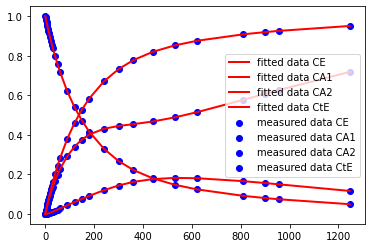

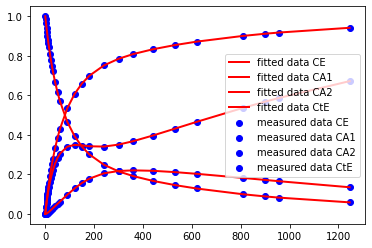

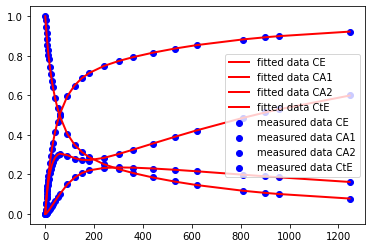

In [40]:
#fit all data simultaneously
exp_1.fit_sys_full(72)
#exp_1.fit_sys_full(96)

In [41]:
#for varying the amount of initial conditions
#inits = [[1,0,0,0,1,0,0,0], [4,0,0,0,2,0,0,0], [8,0,0,0,1.5,0,0,0],[5,0,0,0,5,0,0,0],[1,0,0,0,0.2,0,0,0],[8,0,0,0,8,0,0,0]]

In [101]:
#for varying the timespans
# timespan = [0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246]
# og_len = len(timespan)
# int_lis = []
# for pos in range(len(timespan)-1):
#     intermediate1 = (timespan[pos]*3+ timespan[pos+1])/4
#     intermediate2 = (timespan[pos]+ timespan[pos+1])/2
#     intermediate3 = (timespan[pos]+ timespan[pos+1]*3)/4
#     int_lis.append(intermediate1)
#     int_lis.append(intermediate2)
#     int_lis.append(intermediate3)
    

# for i in range(int(len(int_lis)/3)):
# #     timespan.insert(og_len-(i+1),int_lis[-i-1])
#     timespan.insert(og_len-(i+1),int_lis[-i*3-1])
#     timespan.insert(og_len-(i+1),int_lis[-i*3-2])
#     timespan.insert(og_len-(i+1),int_lis[-i*3-3])
                 

# time = timespan[-1]

In [32]:
#for changing the amount of metics fit to
def get_r2(real,simul):
    real = np.array(real)
    simul = np.array(simul)
    if len(simul)<4 or len(real)<= 4:
        return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2]))
    return (r2_score(((real[2]+real[3])/(real[0] + real[2] + real[3]*2)), ((simul[2]+simul[3])/(simul[0] + simul[2] + simul[3]*2))))

176.57120068031927
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 187064.333
    reduced chi-square = 187064.333
    Akaike info crit   = 74.0846904
    Bayesian info crit = 72.8352472
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.00983950 (init = 0.01)
    k2:  0.01028322 (init = 0.01)
    k3:  0.01010247 (init = 0.01)
    k4:  0.00916382 (init = 0.01)
    k5:  0.01001575 (init = 0.01)
    k6:  0.00991968 (init = 0.01)
62.514839247168666
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 494
    # data points      = 6
    # variables        = 6
    chi-square         = 23448.6308
    reduced chi-square = 23448.6308
    Akaike info crit   = 61.6248475
    Bayesian info crit = 60.3754043
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.01071293 (init = 0.01)
    k2:  0.02308085 (init = 0.01)
 

68.02501286983528
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 6
    # variables        = 6
    chi-square         = 27764.4143
    reduced chi-square = 27764.4143
    Akaike info crit   = 62.6385057
    Bayesian info crit = 61.3890625
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.01068458 (init = 0.01)
    k2:  0.01004604 (init = 0.01)
    k3:  0.01003875 (init = 0.01)
    k4:  0.00958387 (init = 0.01)
    k5:  0.01000727 (init = 0.01)
    k6:  0.00995691 (init = 0.01)
-337.80231291968124
-337.80231291968124
-337.80231291968124
-337.9034239554038
-337.8888146883011
-337.94587429619645
-337.79556035312925
-337.80837257190893
-337.86597524665524
-337.8022980842738
-337.80231291122425
-337.8023129193822
-337.80231291768973
-337.80231291871706
-337.80231291954476
-3423.1106000817877
-4.481366051749528e+17
-3.2892544312346203e+24
-337.80231291968124
[[Fit Statistics]]
    # fitting method   = leastsq

-1284.613950663091
-1305.3097176034705
-1278.8810574813458
-1271.9606784825364
-1260.7365004011679
-1268.6942797670324
-1268.6942748939775
-1268.694274291365
-1268.6942739560973
-1268.694274321397
-1268.6942746629857
-743.8177336638477
-752.3018815034108
-746.8437763788905
-749.5603970516628
-745.3204489875191
-744.434234745558
-742.7715847219838
-743.8177334488541
-743.8177334785751
-743.8177335574542
-743.8177335800175
-743.8177336218415
-743.8177335369138
-9.11676379058557e+25
-743.8177336638477
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 12
    # variables        = 12
    chi-square         = 6964395.11
    reduced chi-square = 6964395.11
    Akaike info crit   = 183.256976
    Bayesian info crit = 189.075856
##  Warning: uncertainties could not be estimated:
    A2:  at initial value
    A3:  at initial value
    A5:  at initial value
    A6:  at initial value
    E1:  at initial value
    E1:  at boundary
    E2:  at in

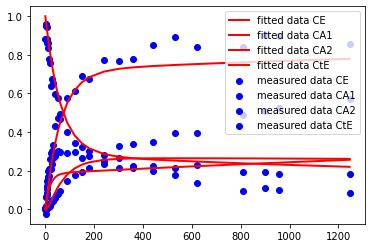

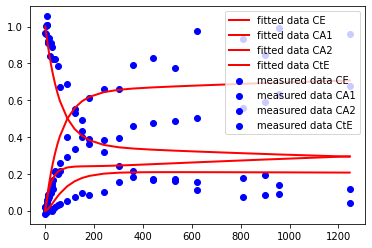

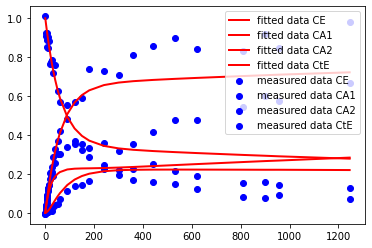

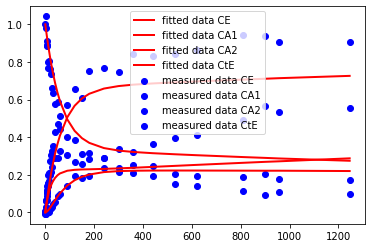

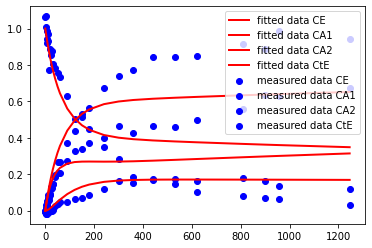

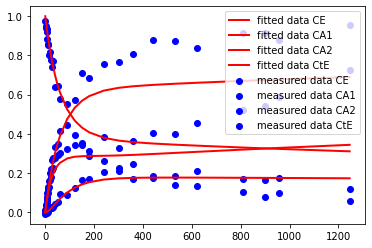

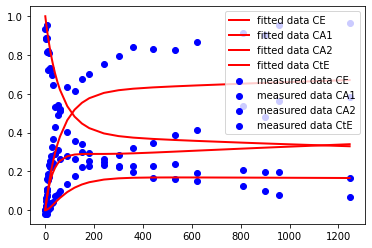

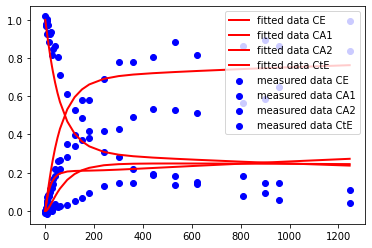

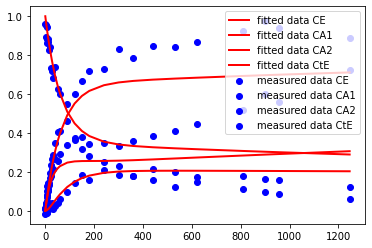

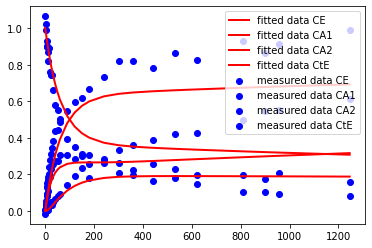

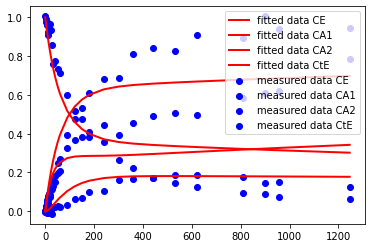

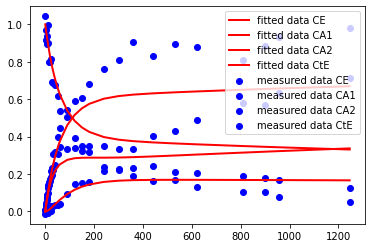

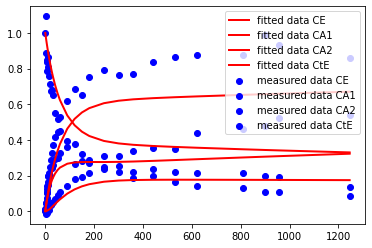

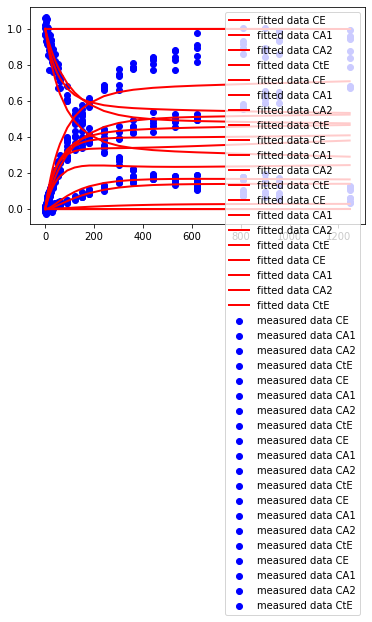

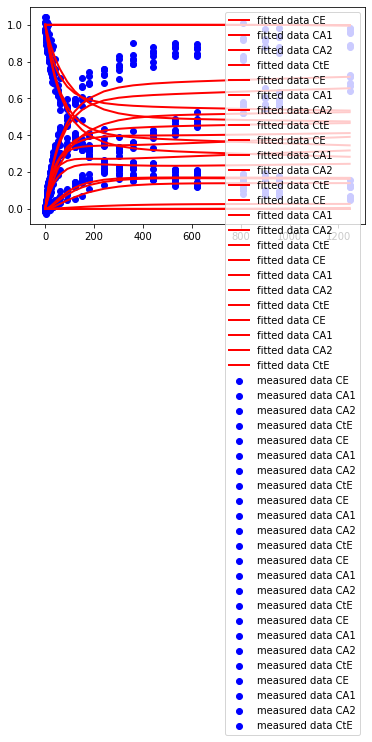

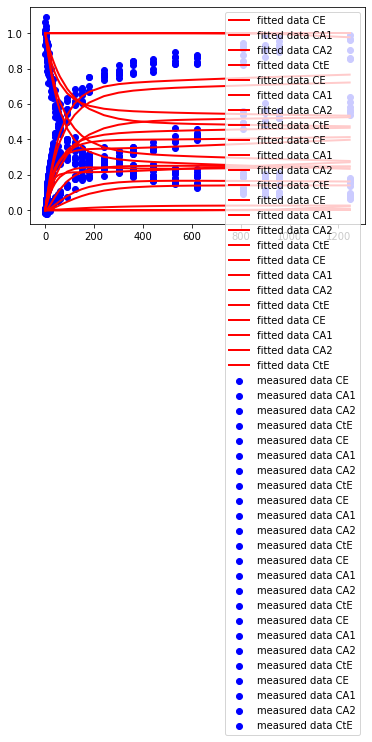

In [34]:
#simple cell to run 5 simulations consecutively
res_lis = []
for i in range(5):
    init_true = [[1,0,0,0,1,0,0,0], [4,0,0,0,2,0,0,0], [8,0,0,0,1.5,0,0,0]]
    exp_1_const = np.array([0.01209668296564242, 0.01517495478255645, 0.0042608145032644508, 0.0897487647678990227, 0.032891811706016034, 0.012690318715024702])
    exp_1_pre_consts = np.array([4, 1.6, 1, 5, 2, 40])
    exp_1_sim_consts = ["k1", "k2", "k3", "k4", "k5", "k6"]
    exp_1_temps = np.array([323,363,393])
    exp_1_E_acts = get_Eact(exp_1_pre_consts,exp_1_const)
    exp_1 = fitting_set(diff,diff,exp_1_pre_consts,exp_1_E_acts, exp_1_sim_consts, exp_1_temps,init_true, init_true)
    exp_1.get_true_data()
    exp_1.fit_sys_all(6)
    exp_1.kin_params_guesses()
    exp_1.fit_sys_full(18)
    scores = exp_1.get_final_scores(6,18)
    res_lis.append(scores)

In [35]:
#some checks
print(res_lis)

[(0.47586065451518017, 0.8517259465884358, 0.6262067713444824), (0.4953367601804136, 0.7864015529816042, 0.6117626773008898), (0.494255048061986, 0.9438583307720338, 0.674096361146005), (0.49947406328177496, 0.9380833181988816, 0.6749177652486176), (0.5029854205723406, 0.9495816850472211, 0.6816239263622929)]


In [ ]:
# exp_1.get_final_scores(24,72)
exp_1.get_final_scores(24,72)

In [46]:
# exp_simp.get_final_scores(18,54)

In [47]:
print(exp_1.real_rates_dict)
print(exp_1.sim_rates_dict)

{'temp': [323, 363, 393], 'k1': [0.005897488188304271, 0.01209668296564243, 0.01883590224472234], 'k2': [0.00852318684494476, 0.015174954782556448, 0.021654807126415244], 'k3': [0.0021673614418580064, 0.004260814503264448, 0.006463196927233503], 'k4': [0.054552268043115824, 0.08974876476789903, 0.12198500798488923], 'k5': [0.019777261717591168, 0.03289181170601603, 0.0450056034587339], 'k6': [0.004679623618940348, 0.012690318715024712, 0.02347146917101018]}
{'temp': [323, 363, 393], 'k1': [0.005897547031767634, 0.012096675394882595, 0.01883868986988791], 'k2': [0.008522822070603536, 0.01517363195022328, 0.021260468744137197], 'k3': [0.002167213724657155, 0.004260333949608958, 0.0062783184754647186], 'k4': [0.054546926827592816, 0.08972181427733507, 0.11415769863934913], 'k5': [0.019777520937372554, 0.03289174440117545, 0.04511818843086963], 'k6': [0.004679436413211453, 0.012688395755715868, 0.022877716887376724]}


In [48]:
print(exp_1.E_ests)

[17509.52676031291, 13808.117853646216, 16078.341521104196, 11229.896224832419, 12430.735970422813, 23963.34220025149]


In [49]:
# from here on it it the same as the new_gen_alg_curve_fit_strat
# A_ests = exp_1.A_ests
# E_ests= exp_1.E_ests
# A_real = [4, 1.6, 1, 5, 2, 40]
# E_real = [-17507.67079081, -14058.09983295, -16473.03587668, -12132.82763899, -12396.90042988, -24312.24532045]

In [50]:
# def check_plots(T,P,S0,Ccat0):
#     R= 8.314
#     D = 8e-2
#     A = np.pi/4*D**2
#     KlaH2 = 4.5e-2 #this value might be possible in very turbulent media, i don't know the nusselt correlation for stirred tank gas/liquid interfaces
#     KH= 1282
#     A_ests = exp_1.A_ests
#     E_ests= exp_1.E_ests
#     k1 = A_ests[0]*np.exp(-E_ests[0]/(R*T))
#     k2 = A_ests[1]*np.exp(-E_ests[1]/(R*T))
#     k3 = A_ests[2]*np.exp(-E_ests[2]/(R*T))
#     k4 = A_ests[3]*np.exp(-E_ests[3]/(R*T))
#     k5 = A_ests[4]*np.exp(-E_ests[4]/(R*T))
#     k6 = A_ests[5]*np.exp(-E_ests[5]/(R*T))
#     init = [S0,0,0,0,Ccat0,0,0,0]
#     def diff(x, init):
#         CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
#         dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
#         dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
#         dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
#         dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
#         dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
#         dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
#         dcatdeaddt = k6*Cprecat
#         dH2uptakedt = k5*Ccat*CH2
#         return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt
    
    
#     sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
#     A_real = [4, 1.6, 1, 5, 2, 40]
#     E_real = [-17507.67079081, -14058.09983295, -16473.03587668, -12132.82763899, -12396.90042988, -24312.24532045]
#     k1 = A_real[0]*np.exp(E_real[0]/(R*T))
#     k2 = A_real[1]*np.exp(E_real[1]/(R*T))
#     k3 = A_real[2]*np.exp(E_real[2]/(R*T))
#     k4 = A_real[3]*np.exp(E_real[3]/(R*T))
#     k5 = A_real[4]*np.exp(E_real[4]/(R*T))
#     k6 = A_real[5]*np.exp(E_real[5]/(R*T))
    

    
#     sol_true = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
#     plt.figure()
#     plt.subplot(1,2,1)
#     plt.plot(sol.t,sol.y[0], label = 'CE')
#     plt.plot(sol.t,sol.y[1], label = 'CA1')
#     plt.plot(sol.t,sol.y[2], label = 'CA2')
#     plt.plot(sol.t,sol.y[3], label = 'CtE')
#     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
#     plt.plot(sol.t,sol.y[5], label = 'Ccat')
#     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
#     plt.legend()
    
#     plt.subplot(1,2,2)
#     plt.plot(sol_true.t,sol_true.y[0], label = 'CE')
#     plt.plot(sol_true.t,sol_true.y[1], label = 'CA1')
#     plt.plot(sol_true.t,sol_true.y[2], label = 'CA2')
#     plt.plot(sol_true.t,sol_true.y[3], label = 'CtE')
#     plt.plot(sol_true.t,sol_true.y[4], label = 'Cprecat')
#     plt.plot(sol_true.t,sol_true.y[5], label = 'Ccat')
#     plt.plot(sol_true.t,sol_true.y[6], label = 'Cdeadcat')
#     plt.title(f'T={T}, P={P}, S0={S0}, Ccat0={Ccat0}')
#     plt.legend()
    
# #     plt.figure()
# #     plt.plot(sol.t,sol.y[0], label = 'CE')
# #     plt.plot(sol.t,sol.y[1], label = 'CA1')
# #     plt.plot(sol.t,sol.y[2], label = 'CA2')
# #     plt.plot(sol.t,sol.y[3], label = 'CtE')
# #     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
# #     plt.plot(sol.t,sol.y[5], label = 'Ccat')
# #     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
# #     plt.legend()
# #     #plt.savefig("MEP_figures/guess_423.png",dpi=300)
    
#     return (r2_score(sol_true.y[0],sol.y[0])+r2_score(sol_true.y[1],sol.y[1])+r2_score(sol_true.y[2],sol.y[2])+r2_score(sol_true.y[3],sol.y[3])+r2_score(sol_true.y[4],sol.y[4]))/5,(r2_score(sol_true.y[5],sol.y[5])+r2_score(sol_true.y[6],sol.y[6]))/2, r2_score(sol_true.y[7],sol.y[7])

(0.9933427209004673, 0.9523750979191703, 0.999367776648188)
(0.9999917148244745, 0.9999668857494092, 0.9999998858587218)
(0.9999993253854885, 0.9999972753709796, 0.9999999537238906)
(0.9999994119697437, 0.9999975796604105, 0.9999998424527817)
(0.999994321527312, 0.9999785555459646, 0.9999977675176057)
(0.9999852557370623, 0.9999490625871816, 0.9999936809999654)
(0.9999690668866495, 0.9999028783207909, 0.9999865265863939)
(0.9998963644114343, 0.9997523265421019, 0.9999588216869422)
(0.9996999749799335, 0.9995269048273601, 0.9999028419292265)
(0.7644233921012701, 0.9913382759395066, 0.9215337937550901)


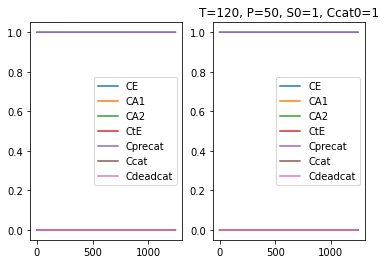

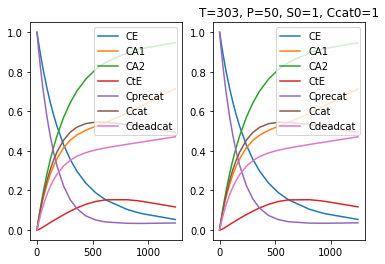

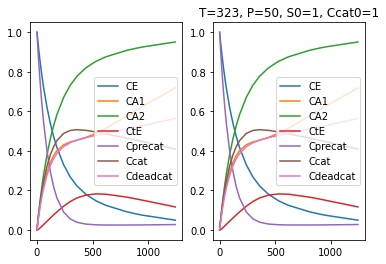

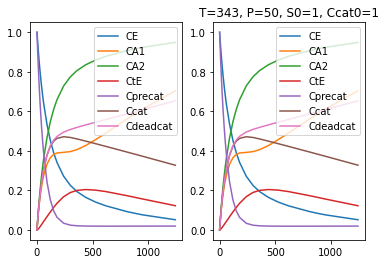

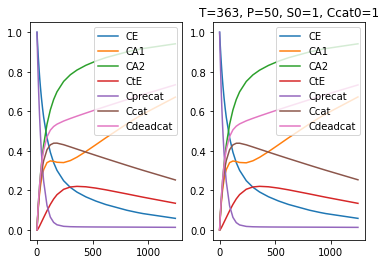

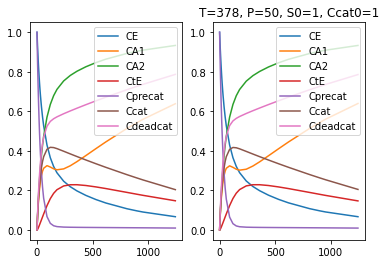

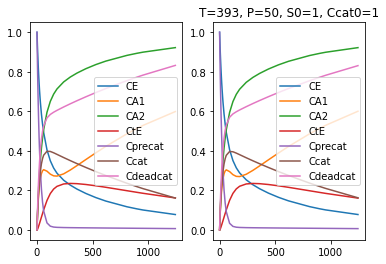

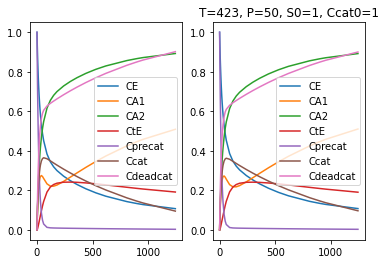

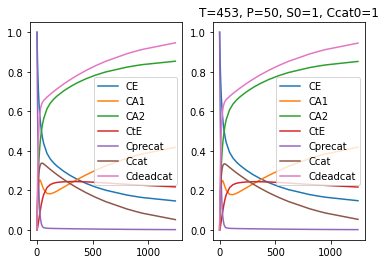

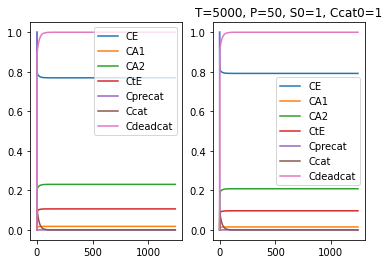

In [58]:
# print(check_plots(120,50,1,1))
# print(check_plots(303,50,1,1))
# print(check_plots(323,50,1,1))
# print(check_plots(343,50,1,1))
# print(check_plots(363,50,1,1))
# print(check_plots(378,50,1,1))
# print(check_plots(393,50,1,1))
# print(check_plots(423,50,1,1))
# print(check_plots(453,50,1,1))
# print(check_plots(1000,50,1,1))

In [55]:
# temp_arr = np.linspace(100,1000,50)
# R= 8.314
# const_lists_sim = [[],[],[],[],[],[],[]]
# const_lists_real = [[],[],[],[],[],[],[]]
# diff_lists = [[],[],[],[],[],[],[]]
# for T in temp_arr:
#     k1 = A_ests[0]*np.exp(-E_ests[0]/(R*T))
#     k2 = A_ests[1]*np.exp(-E_ests[1]/(R*T))
#     k3 = A_ests[2]*np.exp(-E_ests[2]/(R*T))
#     k4 = A_ests[3]*np.exp(-E_ests[3]/(R*T))
#     k5 = A_ests[4]*np.exp(-E_ests[4]/(R*T))
#     k6 = A_ests[5]*np.exp(-E_ests[5]/(R*T))
#     const_lists_sim[0].append(k1)
#     const_lists_sim[1].append(k2)
#     const_lists_sim[2].append(k3)
#     const_lists_sim[3].append(k4)
#     const_lists_sim[4].append(k5)
#     const_lists_sim[5].append(k6)
    
# for T in temp_arr:
#     k1 = A_real[0]*np.exp(E_real[0]/(R*T))
#     k2 = A_real[1]*np.exp(E_real[1]/(R*T))
#     k3 = A_real[2]*np.exp(E_real[2]/(R*T))
#     k4 = A_real[3]*np.exp(E_real[3]/(R*T))
#     k5 = A_real[4]*np.exp(E_real[4]/(R*T))
#     k6 = A_real[5]*np.exp(E_real[5]/(R*T))
#     const_lists_real[0].append(k1)
#     const_lists_real[1].append(k2)
#     const_lists_real[2].append(k3)
#     const_lists_real[3].append(k4)
#     const_lists_real[4].append(k5)
#     const_lists_real[5].append(k6)

# for i in range(len(const_lists_sim[0])):
#     diff_lists[0].append(const_lists_real[0][i]-const_lists_sim[0][i])
#     diff_lists[1].append(const_lists_real[1][i]-const_lists_sim[1][i])
#     diff_lists[2].append(const_lists_real[2][i]-const_lists_sim[2][i])
#     diff_lists[3].append(const_lists_real[3][i]-const_lists_sim[3][i])
#     diff_lists[4].append(const_lists_real[4][i]-const_lists_sim[4][i])
#     diff_lists[5].append(const_lists_real[5][i]-const_lists_sim[5][i])
    
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[0], label = 'k1 sim')
# plt.plot(temp_arr,const_lists_real[0], label = 'k1 real')
# plt.plot(temp_arr,diff_lists[0], label = 'diff')
# plt.legend()
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[1], label = 'k2 sim')
# plt.plot(temp_arr,const_lists_real[1], label = 'k2 real')
# plt.plot(temp_arr,diff_lists[1], label = 'diff')
# plt.legend()
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[2], label = 'k3 sim')
# plt.plot(temp_arr,const_lists_real[2], label = 'k3 real')
# plt.plot(temp_arr,diff_lists[2], label = 'diff')
# plt.legend()
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[3], label = 'k4 sim')
# plt.plot(temp_arr,const_lists_real[3], label = 'k4 real')
# plt.plot(temp_arr,diff_lists[3], label = 'diff')
# plt.legend()
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[4], label = 'k5 sim')
# plt.plot(temp_arr,const_lists_real[4], label = 'k5 real')
# plt.plot(temp_arr,diff_lists[4], label = 'diff')
# plt.legend()
# plt.figure()
# plt.plot(temp_arr,const_lists_sim[5], label = 'k6 sim')
# plt.plot(temp_arr,const_lists_real[5], label = 'k6 real')
# plt.plot(temp_arr,diff_lists[5], label = 'diff')
# plt.legend()
    


(0.9995228394651967, 0.9986090674034643, 0.9999521303192263)
(0.999390935091629, 0.9973768059288846, 0.9999984068844139)
(0.9994075681339533, 0.9967583127493576, 0.9999949986933776)
(0.9989494751109916, 0.9990080462639617, 0.9999962473231909)
(0.9996314130571179, 0.9975564242266097, 0.999996032741247)
(0.999534888625786, 0.9967424702886266, 0.9999913751304744)
(0.9957219794452241, 0.9990755726781906, 0.999984196874567)
(0.9992691218992651, 0.999316290273873, 0.9999860076088244)
(0.9996596706499471, 0.9983469679449891, 0.9999863016559178)


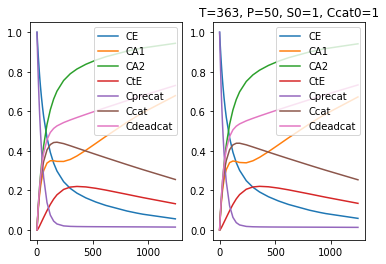

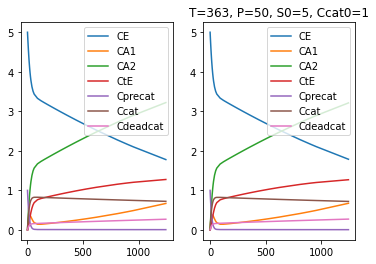

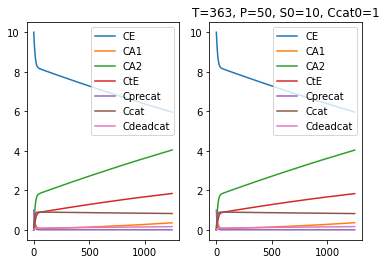

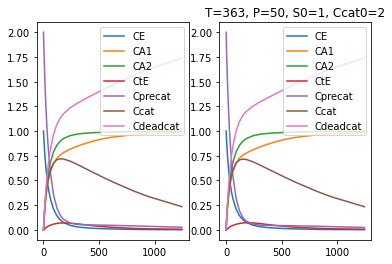

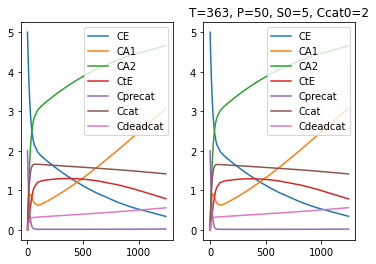

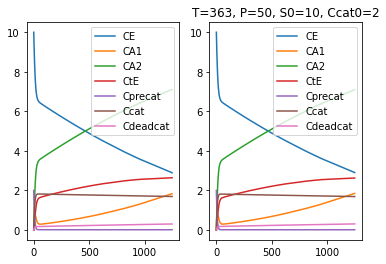

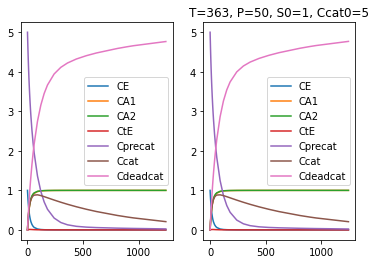

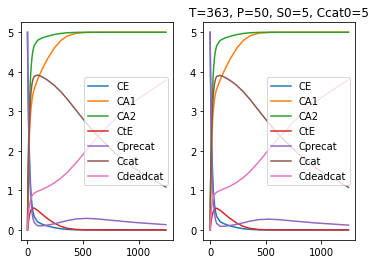

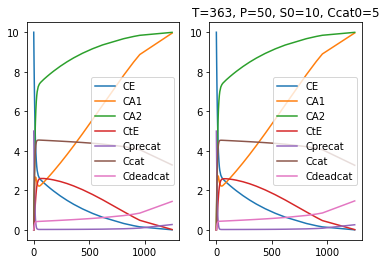

In [56]:
print(check_plots(363,50,1,1))
print(check_plots(363,50,5,1))
print(check_plots(363,50,10,1))
print(check_plots(363,50,1,2))
print(check_plots(363,50,5,2))
print(check_plots(363,50,10,2))
print(check_plots(363,50,1,5))
print(check_plots(363,50,5,5))
print(check_plots(363,50,10,5))

In [57]:
# #use the double line fitting and good guesses to see if this does better
# A_real = [4, 1.6, 1, 5, 2, 40]
# E_real = [-17507.67079081, -14058.09983295, -16473.03587668, -12132.82763899, -12396.90042988, -24312.24532045]
# def get_experiment_real(T,P,S0,Ccat0):
#     R= 8.314
#     KH= 1282
#     CH2 = P/KH
#     k1 = exp_1.A_real[0]*np.exp(-exp_1.E_real[0]/(R*T))
#     k2 = exp_1.A_real[1]*np.exp(-exp_1.E_real[1]/(R*T))
#     k3 = exp_1.A_real[2]*np.exp(-exp_1.E_real[2]/(R*T))
#     k4 = exp_1.A_real[3]*np.exp(-exp_1.E_real[3]/(R*T))
#     k5 = exp_1.A_real[4]*np.exp(-exp_1.E_real[4]/(R*T))
#     k6 = exp_1.A_real[5]*np.exp(-exp_1.E_real[5]/(R*T))
#     init = [S0,0,0,0,Ccat0,0,0,0]
#     def diff(x, init):
#         CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
#         dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
#         dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
#         dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
#         dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
#         dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
#         dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
#         dcatdeaddt = k6*Cprecat
#         dH2uptakedt = k5*Ccat*CH2
#         return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

#     sol = integrate.solve_ivp(diff, [0,time_1], init, t_eval = timespan)
    
# #     plt.plot(sol.t,sol.y[0], label = 'CE')
# #     plt.plot(sol.t,sol.y[1], label = 'CA1')
# #     plt.plot(sol.t,sol.y[2], label = 'CA2')
# #     plt.plot(sol.t,sol.y[3], label = 'CtE')
# #     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
# #     plt.plot(sol.t,sol.y[5], label = 'Ccat')
# #     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
# #     plt.legend()

#     return (np.average(sol.y[1]) + np.average(sol.y[2]))/(S0*Ccat0)
    

In [60]:
#use the double line fitting and good guesses to see if this does better
# A_ests = exp_1.A_ests
# E_ests= exp_1.E_ests
A_ests = [4, 1.6, 1, 5, 2, 40]
E_ests = [17507.67079081, 14058.09983295, 16473.03587668, 12132.82763899, 12396.90042988, 24312.24532045]
def get_experiment_sim(T,P,S0,Ccat0):
    R= 8.314
    KH= 1282
    CH2 = P/KH
    k1 = A_ests[0]*np.exp(-E_ests[0]/(R*T))
    k2 = A_ests[1]*np.exp(-E_ests[1]/(R*T))
    k3 = A_ests[2]*np.exp(-E_ests[2]/(R*T))
    k4 = A_ests[3]*np.exp(-E_ests[3]/(R*T))
    k5 = A_ests[4]*np.exp(-E_ests[4]/(R*T))
    k6 = A_ests[5]*np.exp(-E_ests[5]/(R*T))
    init = [S0,0,0,0,Ccat0,0,0,0]
    def diff(x, init):
        CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
        dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
        dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
        dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
        dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
        dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
        dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
        dcatdeaddt = k6*Cprecat
        dH2uptakedt = k5*Ccat*CH2
        return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

    sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
#     plt.plot(sol.t,sol.y[0], label = 'CE')
#     plt.plot(sol.t,sol.y[1], label = 'CA1')
#     plt.plot(sol.t,sol.y[2], label = 'CA2')
#     plt.plot(sol.t,sol.y[3], label = 'CtE')
#     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
#     plt.plot(sol.t,sol.y[5], label = 'Ccat')
#     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
#     plt.legend()

    return (sol.y[1][-1])/(S0*Ccat0)
    

In [47]:
pbounds = {'T': (293,443), 'P': (40,50), 'S0': (1,10), 'Ccat0' :(0.1,2)}

optimizer = BayesianOptimization(
    f=get_experiment_sim,
    pbounds=pbounds,
)

In [48]:
# #use the double line fitting and good guesses to see if this does better
# A_ests = A_real
# E_ests = E_real
# # A_ests = exp_1.A_ests
# # E_ests= exp_1.E_ests
# # A_ests = [4, 1.6, 1, 5, 2, 40]
# # E_ests = [-17507.67079081, -14058.09983295, -16473.03587668, -12132.82763899, -12396.90042988, -24312.24532045]
# def get_experiment_sim(params):
#     R= 8.314
#     KH= 1282
#     T = params["T"].value
#     P = params["p"].value
#     S0 = params["S0"].value
#     Ccat0 = params["Ccat0"].value
#     CH2 = P/KH
#     k1 = exp_1.A_ests[0]*np.exp(-exp_1.E_ests[0]/(R*T))
#     k2 = exp_1.A_ests[1]*np.exp(-exp_1.E_ests[1]/(R*T))
#     k3 = exp_1.A_ests[2]*np.exp(-exp_1.E_ests[2]/(R*T))
#     k4 = exp_1.A_ests[3]*np.exp(-exp_1.E_ests[3]/(R*T))
#     k5 = exp_1.A_ests[4]*np.exp(-exp_1.E_ests[4]/(R*T))
#     k6 = exp_1.A_ests[5]*np.exp(-exp_1.E_ests[5]/(R*T))
#     init = [S0,0,0,0,Ccat0,0,0,0]
#     def diff(x, init):
#         CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
#         dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
#         dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
#         dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
#         dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
#         dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
#         dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
#         dcatdeaddt = k6*Cprecat
#         dH2uptakedt = k5*Ccat*CH2
#         return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

#     sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan)
    
# #     plt.plot(sol.t,sol.y[0], label = 'CE')
# #     plt.plot(sol.t,sol.y[1], label = 'CA1')
# #     plt.plot(sol.t,sol.y[2], label = 'CA2')
# #     plt.plot(sol.t,sol.y[3], label = 'CtE')
# #     plt.plot(sol.t,sol.y[4], label = 'Cprecat')
# #     plt.plot(sol.t,sol.y[5], label = 'Ccat')
# #     plt.plot(sol.t,sol.y[6], label = 'Cdeadcat')
# #     plt.legend()
#     return 2-((sol.y[1][-1] + sol.y[2][-1])/(S0*Ccat0)),2-((sol.y[1][-1] + sol.y[2][-1])/(S0*Ccat0)),2-((sol.y[1][-1] + sol.y[2][-1])/(S0*Ccat0)),2-((sol.y[1][-1] + sol.y[2][-1])/(S0*Ccat0))
    

In [49]:
# params = Parameters()
# params.add("T" ,value=500, min=100, max=1000)
# params.add("p" ,value=50, min=40, max=50)
# params.add("S0" ,value=1, min=1, max=10)
# params.add("Ccat0" ,value=0.1, min=0.1, max=1)
# results = minimize(get_experiment_sim, params, method='leastsq', max_nfev = 200)

In [50]:
optimizer.maximize(
    init_points=25,
    n_iter=250,
    kappa = 1.5,
)

|   iter    |  target   |   Ccat0   |     P     |    S0     |     T     |
-------------------------------------------------------------------------
|  1        |  0.2485   |  1.209    |  41.22    |  3.767    |  378.3    |
|  2        |  0.2168   |  1.32     |  47.14    |  5.64     |  408.0    |
|  3        |  0.3015   |  1.509    |  40.48    |  4.376    |  410.7    |
|  4        |  0.009595 |  0.434    |  43.02    |  9.346    |  335.9    |
|  5        |  0.04673  |  0.1759   |  44.11    |  2.117    |  358.4    |
|  6        |  0.06604  |  1.356    |  48.08    |  8.379    |  354.5    |
|  7        |  0.06911  |  1.293    |  42.68    |  6.53     |  334.4    |
|  8        |  0.03054  |  0.1887   |  49.27    |  3.154    |  339.5    |
|  9        |  0.01134  |  0.2317   |  42.09    |  6.033    |  339.2    |
|  10       |  0.5338   |  1.527    |  41.57    |  1.986    |  382.0    |
|  11       |  0.5563   |  1.172    |  46.55    |  1.592    |  317.7    |
|  12       |  0.0702   |  0.822    | 

|  67       |  0.3787   |  0.9964   |  48.04    |  2.042    |  320.3    |
|  68       |  0.6049   |  0.9616   |  46.17    |  1.232    |  318.9    |
|  69       |  0.5124   |  1.861    |  41.13    |  1.133    |  380.9    |
|  70       |  0.4361   |  0.8206   |  45.08    |  1.486    |  320.1    |
|  71       |  0.555    |  1.636    |  42.79    |  1.446    |  385.2    |
|  72       |  0.4985   |  1.818    |  42.47    |  2.373    |  381.3    |
|  73       |  0.6834   |  1.316    |  47.1     |  1.076    |  319.7    |
|  74       |  0.6604   |  1.426    |  46.46    |  1.014    |  321.0    |
|  75       |  0.5844   |  0.7358   |  47.99    |  1.017    |  315.3    |
|  76       |  0.7056   |  1.17     |  47.25    |  1.044    |  317.7    |
|  77       |  0.5744   |  1.708    |  46.04    |  1.206    |  323.0    |
|  78       |  0.4108   |  0.746    |  46.7     |  1.461    |  320.0    |
|  79       |  0.6291   |  1.536    |  47.63    |  1.047    |  319.9    |
|  80       |  0.4991   |  1.995    | 

|  135      |  0.4879   |  2.0      |  49.22    |  2.241    |  382.2    |
|  136      |  0.5433   |  1.682    |  40.42    |  1.043    |  384.2    |
|  137      |  0.5562   |  1.049    |  49.99    |  1.709    |  383.8    |
|  138      |  0.4851   |  2.0      |  49.46    |  1.02     |  383.5    |
|  139      |  0.4801   |  2.0      |  45.02    |  1.0      |  388.7    |
|  140      |  0.4381   |  1.862    |  47.34    |  3.549    |  382.0    |
|  141      |  0.2116   |  0.6657   |  49.62    |  2.824    |  383.0    |
|  142      |  0.6582   |  1.431    |  47.43    |  1.078    |  317.0    |
|  143      |  0.5866   |  0.9699   |  49.62    |  1.293    |  385.2    |
|  144      |  0.6918   |  1.014    |  47.3     |  1.047    |  319.1    |
|  145      |  0.4896   |  2.0      |  50.0     |  1.715    |  385.8    |
|  146      |  0.6166   |  1.241    |  48.23    |  1.329    |  385.1    |
|  147      |  0.3225   |  0.6604   |  49.0     |  1.879    |  386.3    |
|  148      |  0.5321   |  1.779    | 

|  203      |  0.1239   |  0.47     |  44.31    |  2.919    |  426.2    |
|  204      |  0.04536  |  0.1701   |  43.76    |  1.989    |  422.5    |
|  205      |  0.5004   |  1.94     |  46.58    |  1.93     |  380.8    |
|  206      |  0.5724   |  0.9787   |  42.12    |  1.0      |  385.7    |
|  207      |  0.514    |  1.206    |  40.11    |  1.08     |  420.9    |
|  208      |  0.3988   |  0.803    |  46.18    |  1.612    |  323.8    |
|  209      |  0.6996   |  1.215    |  46.79    |  1.052    |  317.3    |
|  210      |  0.4758   |  1.991    |  49.64    |  2.127    |  293.0    |
|  211      |  0.6211   |  1.562    |  46.96    |  1.0      |  320.5    |
|  212      |  0.6507   |  1.471    |  48.83    |  1.021    |  319.9    |
|  213      |  0.4921   |  1.124    |  40.1     |  1.48     |  418.9    |
|  214      |  0.6258   |  1.526    |  45.75    |  1.142    |  324.3    |
|  215      |  0.523    |  1.575    |  46.99    |  1.21     |  423.5    |
|  216      |  0.07819  |  0.211    | 

|  271      |  0.5577   |  1.771    |  47.89    |  1.205    |  301.5    |
|  272      |  0.498    |  2.0      |  48.53    |  1.0      |  302.9    |
|  273      |  0.5323   |  1.86     |  40.83    |  1.105    |  299.2    |
|  274      |  0.6748   |  1.074    |  40.6     |  1.016    |  299.1    |
|  275      |  0.6951   |  1.274    |  49.54    |  1.069    |  300.2    |


In [52]:
print(optimizer.max)
params = optimizer.max["params"]

{'target': 0.7203008359366185, 'params': {'Ccat0': 1.0806616406171297, 'P': 48.522838843644976, 'S0': 1.0, 'T': 314.92570259791404}}


In [63]:
#print(get_experiment_sim(params["T"],params["P"],params["S0"],params["Ccat0"]))
print(get_experiment_sim(360,50,5,2))

0.30168990028560455


In [54]:
res_lis = []

for i in range(4):
    pbounds = {'T': (293,443), 'P': (40,50), 'S0': (1,10), 'Ccat0' :(0.1,2)}

    optimizer = BayesianOptimization(
        f=get_experiment_sim,
        pbounds=pbounds,
    )
    optimizer.maximize(
        init_points=25,
        n_iter=250,
        kappa = 1.5,
    )
    res_lis.append(optimizer.max)

|   iter    |  target   |   Ccat0   |     P     |    S0     |     T     |
-------------------------------------------------------------------------
|  1        |  0.00503  |  0.2546   |  43.71    |  8.503    |  304.0    |
|  2        |  0.05534  |  0.1509   |  49.24    |  1.604    |  380.6    |
|  3        |  0.1964   |  0.9772   |  44.44    |  4.327    |  403.8    |
|  4        |  0.06443  |  0.2924   |  44.03    |  2.79     |  387.8    |
|  5        |  0.01357  |  0.4066   |  48.22    |  9.537    |  365.3    |
|  6        |  0.1959   |  1.647    |  44.31    |  4.824    |  342.2    |
|  7        |  0.00811  |  0.1763   |  44.23    |  7.591    |  370.7    |
|  8        |  0.08143  |  0.3997   |  41.12    |  2.467    |  326.9    |
|  9        |  0.403    |  1.885    |  40.47    |  3.926    |  438.3    |
|  10       |  0.0128   |  0.8107   |  46.86    |  9.917    |  307.3    |
|  11       |  0.06552  |  1.973    |  45.81    |  8.727    |  326.6    |
|  12       |  0.1064   |  1.774    | 

|  67       |  0.5268   |  1.886    |  49.25    |  1.093    |  297.5    |
|  68       |  0.4779   |  1.71     |  45.23    |  2.071    |  295.9    |
|  69       |  0.4966   |  0.8615   |  46.91    |  1.316    |  295.6    |
|  70       |  0.4684   |  0.7497   |  48.32    |  1.269    |  301.0    |
|  71       |  0.5356   |  1.722    |  46.53    |  1.732    |  294.2    |
|  72       |  0.5079   |  1.958    |  46.76    |  1.197    |  297.1    |
|  73       |  0.3762   |  1.26     |  45.24    |  2.101    |  293.3    |
|  74       |  0.4974   |  2.0      |  47.88    |  1.0      |  294.1    |
|  75       |  0.4974   |  2.0      |  46.27    |  1.0      |  295.2    |
|  76       |  0.2249   |  1.85     |  46.7     |  3.785    |  294.7    |
|  77       |  0.3891   |  0.5319   |  47.64    |  1.087    |  293.3    |
|  78       |  0.443    |  2.0      |  41.7     |  3.223    |  413.4    |
|  79       |  0.4974   |  2.0      |  43.76    |  1.0      |  296.6    |
|  80       |  0.6742   |  1.207    | 

|  135      |  0.5449   |  1.202    |  48.45    |  1.727    |  413.6    |
|  136      |  0.5584   |  1.259    |  46.74    |  1.123    |  413.9    |
|  137      |  0.1271   |  0.3492   |  46.61    |  1.823    |  415.0    |
|  138      |  0.4657   |  2.0      |  47.3     |  1.049    |  413.1    |
|  139      |  0.4742   |  1.769    |  48.0     |  3.248    |  412.7    |
|  140      |  0.4711   |  1.986    |  44.66    |  1.24     |  413.5    |
|  141      |  0.5589   |  1.498    |  49.82    |  1.522    |  412.8    |
|  142      |  0.2466   |  0.7144   |  49.98    |  2.907    |  412.5    |
|  143      |  0.5546   |  1.376    |  49.54    |  1.836    |  414.9    |
|  144      |  0.4931   |  1.912    |  49.32    |  1.895    |  414.4    |
|  145      |  0.04073  |  0.1112   |  49.25    |  1.087    |  414.1    |
|  146      |  0.522    |  1.724    |  48.92    |  1.62     |  416.2    |
|  147      |  0.4821   |  1.981    |  49.43    |  1.871    |  412.2    |
|  148      |  0.5493   |  1.524    | 

|  203      |  0.5289   |  1.347    |  47.23    |  2.152    |  361.5    |
|  204      |  0.5013   |  1.962    |  47.26    |  1.0      |  359.9    |
|  205      |  0.6638   |  1.199    |  45.83    |  1.0      |  361.5    |
|  206      |  0.4918   |  2.0      |  46.35    |  1.0      |  361.8    |
|  207      |  0.409    |  0.6526   |  45.73    |  1.303    |  360.3    |
|  208      |  0.4014   |  0.5479   |  46.53    |  1.0      |  361.7    |
|  209      |  0.4853   |  1.156    |  45.84    |  2.082    |  361.5    |
|  210      |  0.5419   |  1.772    |  43.66    |  1.553    |  362.2    |
|  211      |  0.6573   |  1.163    |  45.19    |  1.055    |  361.8    |
|  212      |  0.6299   |  1.42     |  45.14    |  1.064    |  361.0    |
|  213      |  0.4971   |  1.974    |  44.92    |  1.0      |  361.7    |
|  214      |  0.044    |  0.1226   |  43.19    |  1.553    |  362.0    |
|  215      |  0.5072   |  1.941    |  48.54    |  1.747    |  361.7    |
|  216      |  0.5219   |  1.874    | 

|  271      |  0.5787   |  0.8149   |  45.73    |  1.0      |  365.2    |
|  272      |  0.5478   |  0.8037   |  46.4     |  1.136    |  366.5    |
|  273      |  0.3582   |  0.5304   |  47.22    |  1.131    |  364.8    |
|  274      |  0.4937   |  1.989    |  45.39    |  1.093    |  366.0    |
|  275      |  0.525    |  1.857    |  47.59    |  1.65     |  366.9    |
|   iter    |  target   |   Ccat0   |     P     |    S0     |     T     |
-------------------------------------------------------------------------
|  1        |  0.3898   |  1.539    |  45.92    |  4.081    |  433.1    |
|  2        |  0.3161   |  1.706    |  41.51    |  3.839    |  360.7    |
|  3        |  0.04085  |  0.948    |  41.1     |  5.633    |  302.0    |
|  4        |  0.04233  |  0.8871   |  47.82    |  5.72     |  304.0    |
|  5        |  0.1819   |  0.4361   |  40.94    |  1.511    |  404.5    |
|  6        |  0.5261   |  1.867    |  41.96    |  1.334    |  344.1    |
|  7        |  0.5206   |  1.543    | 

|  63       |  0.4934   |  2.0      |  47.97    |  1.691    |  365.5    |
|  64       |  0.5246   |  1.578    |  49.68    |  2.488    |  365.7    |
|  65       |  0.609    |  1.534    |  49.63    |  1.072    |  364.5    |
|  66       |  0.51     |  1.937    |  40.35    |  1.02     |  338.4    |
|  67       |  0.5804   |  1.652    |  41.13    |  1.252    |  337.0    |
|  68       |  0.5371   |  1.257    |  49.97    |  2.13     |  364.2    |
|  69       |  0.2319   |  0.3481   |  49.39    |  1.0      |  365.2    |
|  70       |  0.5732   |  1.674    |  48.72    |  1.195    |  363.6    |
|  71       |  0.4923   |  2.0      |  50.0     |  1.0      |  363.6    |
|  72       |  0.4937   |  2.0      |  49.21    |  1.799    |  364.5    |
|  73       |  0.4937   |  1.99     |  47.11    |  1.0      |  363.6    |
|  74       |  0.5278   |  1.434    |  41.05    |  1.875    |  338.3    |
|  75       |  0.6354   |  1.094    |  41.32    |  1.153    |  340.7    |
|  76       |  0.647    |  1.251    | 

|  130      |  0.6694   |  1.377    |  48.76    |  1.025    |  337.9    |
|  131      |  0.5448   |  1.806    |  44.47    |  1.001    |  337.4    |
|  132      |  0.5897   |  1.597    |  48.56    |  1.612    |  337.3    |
|  133      |  0.5595   |  1.657    |  49.97    |  1.956    |  337.3    |
|  134      |  0.5145   |  1.928    |  46.18    |  1.288    |  334.9    |
|  135      |  0.5126   |  1.936    |  45.73    |  1.295    |  333.3    |
|  136      |  0.4945   |  1.99     |  49.49    |  2.116    |  334.8    |
|  137      |  0.543    |  1.815    |  45.54    |  1.0      |  336.3    |
|  138      |  0.6074   |  1.582    |  47.76    |  1.235    |  338.4    |
|  139      |  0.5057   |  1.966    |  47.46    |  1.247    |  333.3    |
|  140      |  0.423    |  1.859    |  47.68    |  3.024    |  333.8    |
|  141      |  0.4941   |  0.6751   |  45.76    |  1.093    |  338.7    |
|  142      |  0.3076   |  0.6138   |  46.07    |  1.573    |  334.2    |
|  143      |  0.6429   |  0.8721   | 

|  198      |  0.6402   |  1.439    |  45.28    |  1.167    |  337.9    |
|  199      |  0.5326   |  1.839    |  49.7     |  1.816    |  339.0    |
|  200      |  0.661    |  0.9964   |  49.98    |  1.085    |  363.1    |
|  201      |  0.6154   |  1.512    |  49.9     |  1.099    |  364.0    |
|  202      |  0.1729   |  1.667    |  49.65    |  9.665    |  442.9    |
|  203      |  0.6539   |  1.326    |  49.54    |  1.143    |  363.5    |
|  204      |  0.4239   |  0.9818   |  48.94    |  1.667    |  293.1    |
|  205      |  0.7072   |  1.151    |  48.75    |  1.027    |  336.8    |
|  206      |  0.4919   |  1.914    |  49.66    |  1.379    |  410.7    |
|  207      |  0.7064   |  1.12     |  49.55    |  1.052    |  338.8    |
|  208      |  0.2505   |  0.4938   |  49.41    |  1.449    |  408.6    |
|  209      |  0.4786   |  1.984    |  49.14    |  1.507    |  413.3    |
|  210      |  0.4571   |  1.656    |  49.49    |  3.558    |  411.5    |
|  211      |  0.1086   |  0.2774   | 

|  266      |  0.4972   |  2.0      |  45.66    |  1.0      |  327.7    |
|  267      |  0.6716   |  1.331    |  42.66    |  1.0      |  328.2    |
|  268      |  0.04692  |  1.04     |  40.52    |  9.927    |  402.4    |
|  269      |  0.2433   |  0.5473   |  47.56    |  1.208    |  442.4    |
|  270      |  0.612    |  1.494    |  42.47    |  1.342    |  327.9    |
|  271      |  0.6823   |  1.114    |  44.58    |  1.073    |  328.8    |
|  272      |  0.03744  |  1.312    |  40.09    |  9.716    |  354.0    |
|  273      |  0.5924   |  1.632    |  44.0     |  1.206    |  329.3    |
|  274      |  0.4897   |  2.0      |  45.48    |  1.0      |  367.9    |
|  275      |  0.4887   |  2.0      |  45.13    |  1.0      |  370.3    |
|   iter    |  target   |   Ccat0   |     P     |    S0     |     T     |
-------------------------------------------------------------------------
|  1        |  0.3067   |  0.9386   |  40.03    |  2.669    |  418.2    |
|  2        |  0.03204  |  0.4182   | 

|  57       |  0.4237   |  0.9011   |  43.38    |  1.565    |  425.2    |
|  58       |  0.4512   |  2.0      |  46.2     |  1.0      |  426.1    |
|  59       |  0.5234   |  1.588    |  44.96    |  1.733    |  422.1    |
|  60       |  0.1223   |  0.3423   |  43.89    |  1.669    |  422.2    |
|  61       |  0.4979   |  2.0      |  49.89    |  1.0      |  298.8    |
|  62       |  0.5219   |  1.396    |  46.59    |  2.088    |  421.4    |
|  63       |  0.4651   |  2.0      |  45.86    |  2.68     |  422.7    |
|  64       |  0.5166   |  1.923    |  44.6     |  1.072    |  297.2    |
|  65       |  0.4558   |  2.0      |  45.83    |  1.0      |  421.2    |
|  66       |  0.4602   |  2.0      |  45.47    |  2.973    |  420.5    |
|  67       |  0.6      |  1.634    |  48.24    |  1.0      |  298.3    |
|  68       |  0.4718   |  2.0      |  48.64    |  2.507    |  421.0    |
|  69       |  0.2897   |  0.5871   |  49.76    |  1.404    |  428.9    |
|  70       |  0.6832   |  1.321    | 

|  125      |  0.455    |  0.6044   |  47.19    |  1.061    |  297.8    |
|  126      |  0.7074   |  1.205    |  47.32    |  1.008    |  298.0    |
|  127      |  0.6746   |  1.395    |  48.39    |  1.002    |  306.3    |
|  128      |  0.5933   |  1.651    |  45.65    |  1.0      |  297.0    |
|  129      |  0.498    |  2.0      |  48.19    |  1.0      |  305.5    |
|  130      |  0.6437   |  1.416    |  48.26    |  1.278    |  307.7    |
|  131      |  0.6186   |  1.576    |  49.37    |  1.064    |  306.2    |
|  132      |  0.659    |  1.443    |  48.9     |  1.05     |  306.5    |
|  133      |  0.0588   |  1.473    |  49.94    |  9.902    |  359.2    |
|  134      |  0.5154   |  1.867    |  40.06    |  1.747    |  354.1    |
|  135      |  0.3757   |  1.567    |  40.03    |  2.962    |  352.5    |
|  136      |  0.7235   |  1.065    |  49.47    |  1.0      |  311.9    |
|  137      |  0.4913   |  2.0      |  40.11    |  1.0      |  355.9    |
|  138      |  0.6117   |  1.478    | 

|  193      |  0.529    |  0.6837   |  49.18    |  1.0      |  361.4    |
|  194      |  0.4933   |  2.0      |  48.85    |  1.043    |  360.1    |
|  195      |  0.4941   |  0.7217   |  49.66    |  1.259    |  365.3    |
|  196      |  0.576    |  1.652    |  49.55    |  1.591    |  362.3    |
|  197      |  0.645    |  1.195    |  47.44    |  1.261    |  364.5    |
|  198      |  0.5285   |  1.019    |  48.09    |  1.74     |  365.1    |
|  199      |  0.6257   |  1.432    |  47.86    |  1.166    |  367.2    |
|  200      |  0.4317   |  0.5862   |  47.37    |  1.0      |  366.5    |
|  201      |  0.4921   |  2.0      |  48.3     |  1.156    |  368.1    |
|  202      |  0.5277   |  1.844    |  46.24    |  1.453    |  367.4    |
|  203      |  0.5702   |  1.29     |  48.03    |  1.889    |  367.4    |
|  204      |  0.4967   |  1.976    |  47.35    |  1.063    |  366.8    |
|  205      |  0.5928   |  1.183    |  48.99    |  1.68     |  367.1    |
|  206      |  0.5826   |  1.441    | 

|  261      |  0.5629   |  1.624    |  42.64    |  1.691    |  354.5    |
|  262      |  0.5188   |  1.892    |  40.85    |  1.25     |  348.9    |
|  263      |  0.538    |  1.792    |  45.7     |  1.382    |  371.0    |
|  264      |  0.515    |  1.884    |  46.36    |  1.054    |  371.8    |
|  265      |  0.5764   |  1.626    |  44.45    |  1.272    |  367.5    |
|  266      |  0.6443   |  1.287    |  46.52    |  1.071    |  369.0    |
|  267      |  0.5367   |  1.787    |  48.72    |  1.946    |  366.7    |
|  268      |  0.6394   |  1.291    |  46.72    |  1.07     |  372.4    |
|  269      |  0.6373   |  1.007    |  48.36    |  1.063    |  373.3    |
|  270      |  0.4875   |  1.982    |  49.95    |  2.579    |  356.9    |
|  271      |  0.09629  |  0.1838   |  44.76    |  1.046    |  364.0    |
|  272      |  0.6301   |  1.273    |  47.22    |  1.305    |  372.8    |
|  273      |  0.02594  |  0.1353   |  49.16    |  2.92     |  354.6    |
|  274      |  0.1407   |  0.2353   | 

|  52       |  0.4901   |  2.0      |  46.03    |  1.84     |  373.8    |
|  53       |  0.4759   |  1.96     |  46.72    |  2.846    |  374.0    |
|  54       |  0.4855   |  2.0      |  44.58    |  2.136    |  377.1    |
|  55       |  0.474    |  1.687    |  47.1     |  3.123    |  399.5    |
|  56       |  0.4889   |  1.966    |  47.97    |  2.092    |  400.1    |
|  57       |  0.2146   |  0.5852   |  47.52    |  2.382    |  400.2    |
|  58       |  0.5337   |  1.715    |  46.73    |  1.861    |  398.4    |
|  59       |  0.5009   |  1.908    |  47.66    |  1.894    |  398.8    |
|  60       |  0.477    |  1.542    |  47.1     |  2.952    |  397.9    |
|  61       |  0.5386   |  1.609    |  42.69    |  1.982    |  378.2    |
|  62       |  0.4688   |  2.0      |  48.66    |  3.117    |  399.2    |
|  63       |  0.5877   |  1.305    |  42.87    |  1.472    |  378.6    |
|  64       |  0.479    |  2.0      |  45.43    |  2.285    |  398.7    |
|  65       |  0.3767   |  0.6836   | 

|  119      |  0.2448   |  0.4114   |  47.99    |  1.263    |  353.3    |
|  120      |  0.3558   |  1.977    |  40.53    |  3.683    |  356.1    |
|  121      |  0.4109   |  0.7924   |  46.4     |  1.677    |  352.2    |
|  122      |  0.6064   |  1.562    |  47.26    |  1.169    |  353.2    |
|  123      |  0.2257   |  2.0      |  47.81    |  5.635    |  352.6    |
|  124      |  0.6787   |  1.131    |  48.91    |  1.093    |  356.7    |
|  125      |  0.4941   |  2.0      |  46.85    |  1.0      |  352.9    |
|  126      |  0.6365   |  1.448    |  49.14    |  1.057    |  356.9    |
|  127      |  0.6183   |  1.408    |  49.06    |  1.574    |  357.3    |
|  128      |  0.4802   |  1.712    |  44.84    |  1.202    |  438.6    |
|  129      |  0.197    |  0.4774   |  43.4     |  1.318    |  437.0    |
|  130      |  0.5012   |  1.558    |  46.02    |  1.444    |  439.7    |
|  131      |  0.5886   |  1.633    |  47.49    |  1.0      |  351.7    |
|  132      |  0.4555   |  2.0      | 

|  187      |  0.5982   |  1.596    |  42.92    |  1.043    |  343.7    |
|  188      |  0.5527   |  1.034    |  41.42    |  1.412    |  343.5    |
|  189      |  0.262    |  0.629    |  40.61    |  1.718    |  342.6    |
|  190      |  0.57     |  1.673    |  42.13    |  1.41     |  344.1    |
|  191      |  0.6422   |  1.456    |  49.16    |  1.035    |  347.8    |
|  192      |  0.7027   |  1.146    |  50.0     |  1.0      |  349.1    |
|  193      |  0.5767   |  1.686    |  50.0     |  1.0      |  349.8    |
|  194      |  0.4936   |  1.995    |  40.04    |  1.581    |  347.2    |
|  195      |  0.5513   |  1.394    |  49.95    |  1.257    |  421.0    |
|  196      |  0.5691   |  0.9461   |  42.72    |  1.271    |  343.2    |
|  197      |  0.6652   |  1.296    |  46.33    |  1.0      |  354.3    |
|  198      |  0.5032   |  1.734    |  49.86    |  2.707    |  420.5    |
|  199      |  0.5234   |  1.18     |  48.81    |  1.836    |  421.9    |
|  200      |  0.03011  |  0.1016   | 

|  255      |  0.5687   |  1.701    |  43.92    |  1.384    |  337.3    |
|  256      |  0.6563   |  1.399    |  48.61    |  1.0      |  348.1    |
|  257      |  0.5661   |  1.734    |  46.19    |  1.181    |  333.2    |
|  258      |  0.4528   |  1.502    |  46.85    |  2.488    |  333.6    |
|  259      |  0.6489   |  1.436    |  46.63    |  1.006    |  340.0    |
|  260      |  0.4588   |  1.364    |  45.27    |  2.239    |  331.7    |
|  261      |  0.5146   |  1.928    |  45.16    |  1.172    |  332.8    |
|  262      |  0.5235   |  1.892    |  45.56    |  1.086    |  334.4    |
|  263      |  0.6204   |  0.8418   |  46.87    |  1.064    |  331.8    |
|  264      |  0.05714  |  0.27     |  47.58    |  2.553    |  331.7    |
|  265      |  0.5093   |  1.951    |  46.79    |  1.325    |  331.3    |
|  266      |  0.6974   |  1.199    |  47.37    |  1.005    |  340.2    |
|  267      |  0.1072   |  0.1674   |  47.05    |  1.03     |  333.0    |
|  268      |  0.3792   |  0.64     | 

In [55]:
print(res_lis)

[{'target': 0.706490225775542, 'params': {'Ccat0': 1.2015221458877754, 'P': 48.331928220731974, 'S0': 1.0336594483919805, 'T': 300.42905838627473}}, {'target': 0.7143009024129212, 'params': {'Ccat0': 1.141558158320632, 'P': 49.60302615877269, 'S0': 1.0, 'T': 337.44382797297436}}, {'target': 0.7234885682414557, 'params': {'Ccat0': 1.065192563649038, 'P': 49.46939194699212, 'S0': 1.0, 'T': 311.89231227563687}}, {'target': 0.7049763397010802, 'params': {'Ccat0': 1.1815844181818616, 'P': 47.97571362521395, 'S0': 1.03331332666112, 'T': 331.34562829393326}}]
